In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

In [2]:
class QuantumLinear(nn.Module):
    def __init__(self, input_dim, n_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.n_layers = n_layers

        # dev = qml.device("default.qubit", wires=input_dim, parallel=True)
        dev = qml.device("default.qubit", wires=input_dim)

        def circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(input_dim))
            qml.templates.BasicEntanglerLayers(weights, wires=range(input_dim))
            return [qml.expval(qml.PauliZ(i)) for i in range(input_dim)]

        qnode = qml.QNode(circuit, dev, interface="torch")
        weight_shapes = {"weights": (n_layers, input_dim)}
        self.layer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        return self.layer(x)

class QuantumGLU(nn.Module):
    def __init__(self, input_dim, n_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.n_layers = n_layers

        # Use QuantumLinear instances for gate and feature paths
        self.q_gate = QuantumLinear(input_dim, n_layers)
        self.q_feature = QuantumLinear(input_dim, n_layers)

    def forward(self, x):
        x = x.to(torch.double).requires_grad_()
        gate = torch.sigmoid(self.q_gate(x))
        feature = self.q_feature(x)
        return gate * feature

class QuantumGRN(nn.Module):

    def __init__(self, input_dim, n_layers=2):
        super().__init__()
        self.input_dim = input_dim

        self.q_linear_a = QuantumLinear(input_dim, n_layers)
        self.q_linear_eta2 = QuantumLinear(input_dim, n_layers)
        self.qglu = QuantumGLU(input_dim, n_layers)

        # if input_dim > 1:
        #     self.layer_norm = nn.LayerNorm(input_dim, dtype=torch.double)
        # else:
        #     self.layer_norm = nn.Identity()

    def forward(self, a, c=None):
        a = a.to(torch.double).requires_grad_()
        c = torch.zeros_like(a) if c is None else c.to(torch.double)

        eta1 = F.elu(self.q_linear_a(a))
        eta2 = self.q_linear_eta2(eta1)
        eta3 = self.qglu(eta2)

        residual = a + eta3
        # return self.layer_norm(residual)

        return residual

class QuantumVariableSelectionNetwork(nn.Module):
    def __init__(self, num_vars, d_model):
        super(QuantumVariableSelectionNetwork, self).__init__()  # <- fixed this line
        self.num_vars = num_vars
        self.d_model = d_model
        
        self.selection_grn = QuantumGRN(input_dim=num_vars * d_model)

        # Shared GRN for processing each variable (weights shared across all variables)
        self.variable_grn = QuantumGRN(input_dim=d_model)

    def forward(self, xi_t, context=None):
        """
        xi_t: Tensor of shape (batch_size, num_vars, d_model)
        context: Tensor of shape (batch_size, context_dim), or None
        """
        B, m_x, d_model = xi_t.shape
        assert m_x == self.num_vars and d_model == self.d_model

        # ----- Variable selection weights -----
        xi_flat = xi_t.view(B, -1)

        # Compute raw selection logits and apply softmax
        selection_logits = self.selection_grn(xi_flat, context)  # (B, m_x * d_model)
        v_weights = F.softmax(selection_logits.view(B, m_x), dim=-1)  # (B, m_x)

        # ----- Processed feature vectors -----
        xi_reshaped = xi_t.reshape(B * m_x, d_model)
        xi_proc = self.variable_grn(xi_reshaped)  # (B * m_x, d_model)
        xi_proc = xi_proc.view(B, m_x, d_model)

        # ----- Weighted sum -----
        v_weights = v_weights.unsqueeze(-1)  # (B, m_x, 1)
        output = torch.sum(v_weights * xi_proc, dim=1)  # (B, d_model)

        return output, v_weights

class QuantumSingleHeadAttention(nn.Module):
    def __init__(self, d_model, n_layers=2):
        super().__init__()
        self.d_model = d_model
        self.q_query = QuantumLinear(d_model, n_layers)
        self.q_key = QuantumLinear(d_model, n_layers)
        self.q_value = QuantumLinear(d_model, n_layers)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        x = x.to(torch.double)

        # Reshape to apply QuantumLinear: (B*T, d_model)
        x_reshaped = x.view(-1, d_model)

        Q = self.q_query(x_reshaped).view(batch_size, seq_len, d_model)
        K = self.q_key(x_reshaped).view(batch_size, seq_len, d_model)
        V = self.q_value(x_reshaped).view(batch_size, seq_len, d_model)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_model ** 0.5)  # (B, T, T)
        attn_weights = self.softmax(scores)                              # (B, T, T)
        attn_output = torch.matmul(attn_weights, V)                      # (B, T, d_model)

        return attn_output, attn_weights

class QuantumMyModel(nn.Module):
    def __init__(self, num_vars_k, num_vars_T, d_model=1, lstm_hidden=1):
        super(QuantumMyModel, self).__init__()

        self.vsn_k = QuantumVariableSelectionNetwork(num_vars=num_vars_k, d_model=d_model)
        self.vsn_T = QuantumVariableSelectionNetwork(num_vars=num_vars_T, d_model=d_model)

        self.lstm_cell = nn.LSTMCell(input_size=1, hidden_size=lstm_hidden)
        self.lstm_cell = self.lstm_cell.to(torch.double)  # Ensure LSTM uses double precision

        self.glu1 = QuantumGLU(input_dim=1)
        self.grn1 = QuantumGRN(input_dim=1)
        self.attn = QuantumSingleHeadAttention(d_model=1)
        self.grn2 = QuantumGRN(input_dim=1)
        self.glu2 = QuantumGLU(input_dim=1)

        # Convert all quantum/classical modules to double
        self.vsn_k = self.vsn_k.to(torch.double)
        self.vsn_T = self.vsn_T.to(torch.double)
        self.glu1 = self.glu1.to(torch.double)
        self.grn1 = self.grn1.to(torch.double)
        self.attn = self.attn.to(torch.double)
        self.grn2 = self.grn2.to(torch.double)
        self.glu2 = self.glu2.to(torch.double)

    def forward(self, x_k, x_T):
        """
        x_k: Tensor of shape (B, k, num_vars_k)
        x_T: Tensor of shape (B, T, num_vars_T)
        """
        B, k, num_vars_k = x_k.shape
        _, T, num_vars_T = x_T.shape

        vsn_outputs = []

        # Step 1: VSN Encoding
        for t in range(k):
            xi = x_k[:, t, :].view(B, num_vars_k, 1)
            out, _ = self.vsn_k(xi)
            vsn_outputs.append(out)

        for t in range(T):
            xi = x_T[:, t, :].view(B, num_vars_T, 1)
            out, _ = self.vsn_T(xi)
            vsn_outputs.append(out)

        vsn_seq = torch.stack(vsn_outputs, dim=1)  # (B, k+T, 1)

        # Step 2: LSTM processing
        h_t = torch.zeros(B, 1, dtype=vsn_seq.dtype, device=vsn_seq.device)
        c_t = torch.zeros(B, 1, dtype=vsn_seq.dtype, device=vsn_seq.device)
        lstm_outs = []

        for t in range(k + T):
            x_t = vsn_seq[:, t, :]  # (B, 1)
            h_t, c_t = self.lstm_cell(x_t, (h_t, c_t))  # (B, 1)
            lstm_outs.append(h_t)

        lstm_seq = torch.stack(lstm_outs, dim=1)  # (B, k+T, 1)

        # Step 3: Residual + GLU
        combined1 = self.glu1(lstm_seq) + vsn_seq  # (B, k+T, 1)

        # Step 4: GRN
        grn_out = self.grn1(combined1)  # (B, k+T, 1)

        # Step 5: Attention
        attn_out, _ = self.attn(grn_out)  # (B, k+T, 1)

        # Step 6: GLU + GRN again
        combined2 = self.glu1(attn_out) + grn_out
        grn_out2 = self.grn2(combined2)
        final = self.glu2(grn_out2) + combined1  # (B, k+T, 1)

        return final[:, -T:, :]  # (B, T, 1)   

In [ ]:
# --- Define quantile loss ---
def quantile_loss(y_pred, y_true, q=0.5):
    error = y_true - y_pred
    return torch.max((q - 1) * error, q * error).mean()

# --- Load data ---
df = pd.read_csv("AXISBANK.csv")
# cols = ['Open', 'High', 'Low', 'Last']
cols = ['Open', 'High', 'Low', 'Prev Close', 'Last', 'VWAP']
target_col = 'Close'


# Convert to tensor
full_X = torch.tensor(df[cols].values, dtype=torch.float32)
full_y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(-1)


# --- Hyperparameters ---
k = 2   # Number of past steps
T = 2   # Number of future steps
q = 0.5  # Quantile for loss
learning_rate = 0.1
num_epochs = 100
epoch_losses = []

# --- Initialize your quantum model ---
model = QuantumMyModel(num_vars_k=6, num_vars_T=6).to(torch.double)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]

        x_k = window[:k].unsqueeze(0)
        # x_T = window[k:k+T, 0].view(1, T, 1)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # print(total_loss)
    epoch_losses.append(total_loss)

    # print(loss)
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 0 - Loss: 6.3397
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.9588772010424, 26.372183756235504, 26.367116718335904, 25.579347284848705, 25.57947907746286, 25.751316158235355, 25.746363151227953, 24.469172701776362, 24.524519669546898, 23.970439980132856, 24.020008006296184, 24.16123244480365, 24.195427806957934, 23.807024727005473, 23.800100223606677, 24.984996389827675, 24.985842622402384, 25.956554335146627, 25.965540921426133, 25.506427350638987, 25.5101

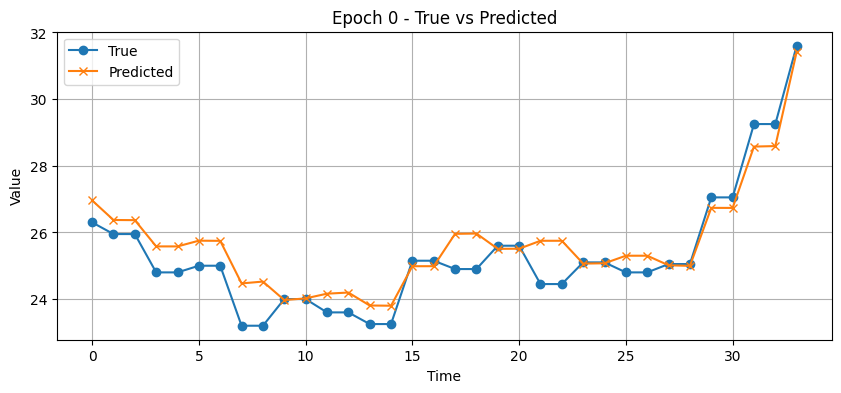

Epoch 15 - Loss: 3.4867
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.60219536829969, 25.827839556210975, 25.83270671473838, 25.090804974988977, 25.09392316838321, 25.21650089090068, 25.194644698550135, 24.215592143859435, 24.197201580069063, 23.832269727223604, 23.809598652666327, 23.863498716163303, 23.810622930201145, 23.516608182154513, 23.534785081130305, 24.58218129887516, 24.60397752747829, 25.34531500500795, 25.345156793498248, 25.016934866734566, 25.042817

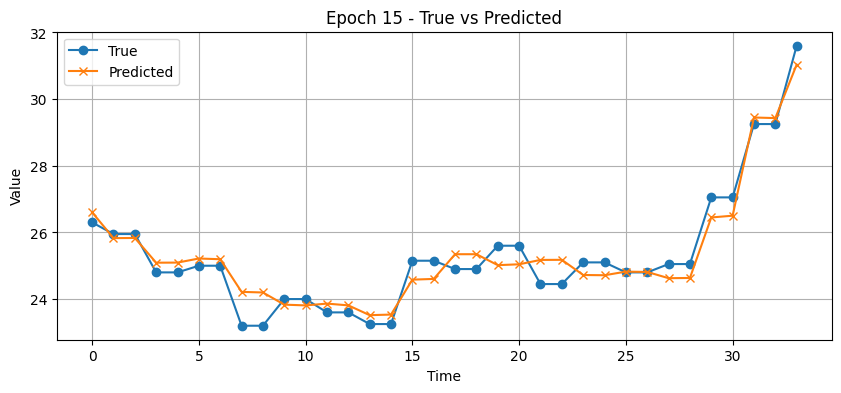

Epoch 30 - Loss: 3.6464
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.900767050910034, 26.115417276475302, 26.134295405936793, 25.259631961640267, 25.25879648673461, 25.393383801924703, 25.404499711323158, 24.259965098548875, 24.24239146495373, 23.800634084419958, 23.791861865886567, 23.86623547783682, 23.85757971664314, 23.47847641014603, 23.48604657717971, 24.739898889296935, 24.753168867643307, 25.62077265424949, 25.611086118006842, 25.223404445183714, 25.223174

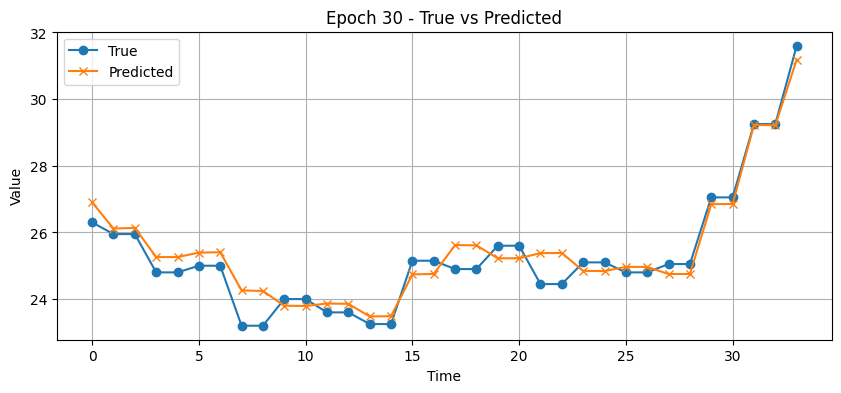

Epoch 100 - Loss: 3.4646
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.77878630224207, 25.728268709330408, 25.733938789782435, 25.068215092557246, 25.065980941140566, 25.157102337645775, 25.1832313135447, 24.38226201987542, 24.38968991563064, 24.035696268694075, 24.018280045013434, 24.070390782502603, 24.043353801206752, 23.770218254154866, 23.773616696736102, 24.70184618108946, 24.737401400297106, 25.26745471259266, 25.295019369629795, 25.07898325686044, 25.084846

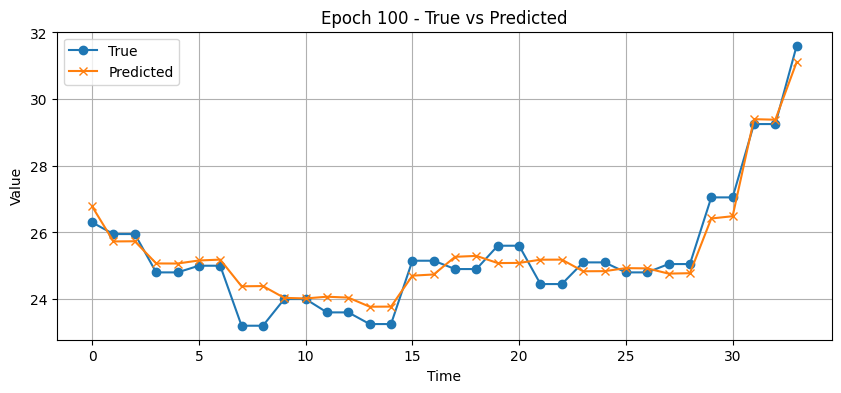

In [68]:

# --- Define quantile loss ---
def quantile_loss(y_pred, y_true, q=0.5):
    error = y_true - y_pred
    return torch.max((q - 1) * error, q * error).mean()

# --- Load data ---
df = pd.read_csv("AXISBANK.csv")
cols = ['Open', 'High', 'Low', 'Prev Close', 'Last', 'VWAP']
target_col = 'Close'

# Convert to tensor
full_X = torch.tensor(df[cols].values, dtype=torch.float32)
full_y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(-1)

# --- Hyperparameters ---
k = 2   # Number of past steps
T = 2   # Number of future steps
q = 0.5  # Quantile for loss
learning_rate = 0.1
epoch_losses = []

# --- Visualization Helpers ---
def run_prediction(model, full_X, full_y, k, T):
    true_vals = []
    pred_vals = []
    model.eval()
    with torch.no_grad():
        for i in range(20 - (k + T) + 1):
            window = full_X[i:i+k+T]
            window_y = full_y[i:i+k+T]

            x_k = window[:k].unsqueeze(0)
            x_T = window[k:k+T].unsqueeze(0)
            y_T = window_y[k:k+T].unsqueeze(0)

            y_pred = model(x_k, x_T)
            # true_vals.extend(y_T.squeeze(-1).cpu().numpy())
            # pred_vals.extend(y_pred.squeeze(-1).cpu().numpy())
            true_vals.extend(y_T.squeeze().tolist())
            pred_vals.extend(y_pred.squeeze().tolist())
    return true_vals, pred_vals
 
def plot_predictions(epoch, true_vals, pred_vals):
    print(true_vals)
    print(pred_vals)
    plt.figure(figsize=(10, 4))
    plt.plot(true_vals, label='True', marker='o')
    plt.plot(pred_vals, label='Predicted', marker='x')
    plt.title(f"Epoch {epoch} - True vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Initialize your model ---
model = QuantumMyModel(num_vars_k=6, num_vars_T=6)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# === Stage 1: Epoch 0 to 15 ===
for epoch in range(0, 16):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]
        x_k = window[:k].unsqueeze(0)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_losses.append(total_loss)
    if epoch == 0 or epoch == 15:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
        true_vals, pred_vals = run_prediction(model, full_X, full_y, k, T)
        plot_predictions(epoch, true_vals, pred_vals)

# === Stage 2: Epoch 16 to 30 ===
for epoch in range(16, 31):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]
        x_k = window[:k].unsqueeze(0)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_losses.append(total_loss)
    if epoch == 30:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
        true_vals, pred_vals = run_prediction(model, full_X, full_y, k, T)
        plot_predictions(epoch, true_vals, pred_vals)

# === Stage 3: Epoch 31 to 100 ===
for epoch in range(31, 101):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]
        x_k = window[:k].unsqueeze(0)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_losses.append(total_loss)
    if epoch == 100:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
        true_vals, pred_vals = run_prediction(model, full_X, full_y, k, T)
        plot_predictions(epoch, true_vals, pred_vals)


In [40]:
# Save model weights only
torch.save(model.state_dict(), "Quantum_trained_model.pth")

# Save losses as a Python pickle file
import pickle
with open("Quantum_epoch_losses.pkl", "wb") as f:
    pickle.dump(epoch_losses, f)


In [41]:
# Reinitialize the model structure
model = QuantumMyModel(num_vars_k=4, num_vars_T=4)

# Load model weights
model.load_state_dict(torch.load("Quantum_trained_model.pth"))
model.eval()  # or model.train() if continuing training

# Load losses
import pickle
with open("Quantum_epoch_losses.pkl", "rb") as f:
    epoch_losses = pickle.load(f)


[6.339681417218581, 4.7574477987247565, 5.27912002930473, 3.9508253089133314, 4.250162054953767, 4.256377320543911, 4.0830168586986515, 4.1031912569212246, 3.6226047400042223, 3.57473814712837, 3.4455491144341828, 3.44222400567622, 3.2011251999220063, 4.007612752812316, 3.3475236149469643, 3.486712193193111, 3.3194248839598393, 3.5107065499031878, 3.450215857682193, 3.287830091707481, 3.655348568755148, 3.6150106720092827, 3.291967780278834, 3.8036289903508598, 3.394312580673522, 3.723297126840034, 3.579428199100814, 3.39815424611964, 3.8270854514910013, 4.057557349215693, 3.6464198996093717, 3.8686081146926297, 4.0313324675821764, 3.384259286446759, 3.7622936121500876, 3.67341844054479, 3.489082652383768, 3.3876666069223482, 3.759622514862115, 4.2622608723297155, 3.6344645767205215, 3.8914227417735257, 4.523313561581928, 3.7814248739926812, 3.2991203348169345, 4.222746313391049, 3.451474233930612, 3.4965314036849033, 3.294669762903702, 3.5494172783290576, 3.449017361960233, 3.40773309

C:\Users\91876\AppData\Local\Temp\ipykernel_15072\40952148.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


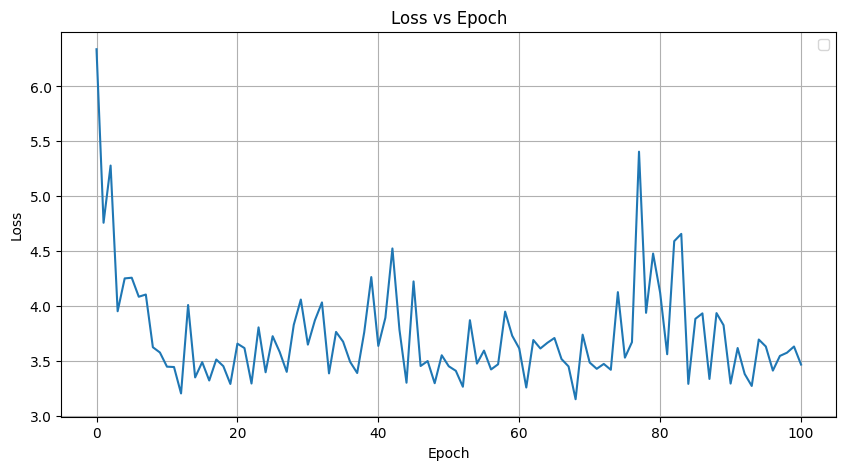

In [69]:
plt.figure(figsize=(10, 5))
print(epoch_losses)
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [83]:
def quantile_loss(y_pred, y_true, q=0.5):
    error = y_true - y_pred
    return torch.max((q - 1) * error, q * error).mean()
df = pd.read_csv("AXISBANK.csv")
# cols = ['Open', 'High', 'Low', 'Last']
cols = ['Open', 'High', 'Low', 'Prev Close', 'Last', 'VWAP']
target_col = 'Close'

k = 2   # Number of past steps
T = 2   # Number of future steps
q = 0.5  # Quantile for loss

# Convert to tensor
full_X = torch.tensor(df[cols].values, dtype=torch.float32)
full_y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(-1)
test_start = 18
test_end = 26
test_loss = 0.0
test_count = 0

with torch.no_grad():
    for i in range(test_start, test_end - (k + T) + 1):
        # window = full_features[i:i+k+T]
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]

        x_k = window[:k].unsqueeze(0)
        # x_T = window[k:k+T, 0].view(1, T, 1)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        test_loss += loss.item()
        test_count += 1
       

avg_test_loss = test_loss / test_count if test_count > 0 else float('nan')
print(f"\nTest Loss (index {test_start} to {test_end}): {avg_test_loss:.4f}")
print(test_count)


Test Loss (index 18 to 26): 0.8381
5


In [84]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 158


[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.691030123573814, 25.71931226053562, 25.71485609637923, 24.97819705853498, 24.975451921928894, 25.07530010920109, 25.081344659686277, 24.245970616863588, 24.244239671713345, 23.85216034438883, 23.848034242689323, 23.899017310104025, 23.890685812315343, 23.597222244924385, 23.599330237412463, 24.61920015838754, 24.629463041340845, 25.208635050439945, 25.210455176298076, 24.959187088659657, 24.962575126321042, 25.054367574

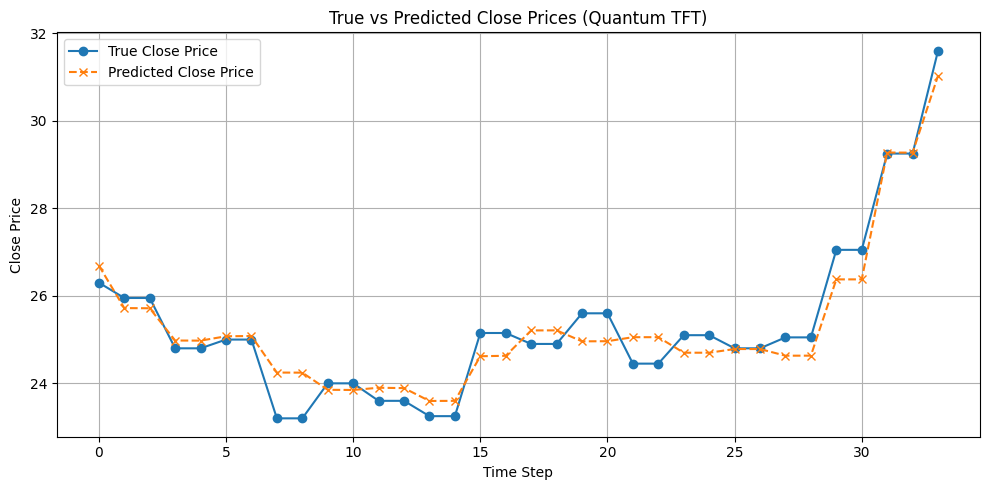

In [8]:
true_vals = []
pred_vals = []

with torch.no_grad():
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]

        x_k = window[:k].unsqueeze(0)
        # x_T = window[k:k+T, 0].view(1, T, 1)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        
        true_vals.extend(y_T.squeeze().tolist())
        pred_vals.extend(y_pred.squeeze().tolist())
print(true_vals)
print(pred_vals)
# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(true_vals, label='True Close Price', marker='o')
plt.plot(pred_vals, label='Predicted Close Price', linestyle='--', marker='x')
plt.title('True vs Predicted Close Prices (Quantum TFT)')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

True values (Close): [34.54999923706055, 37.349998474121094]
Predicted values (Close): [34.58101725802779, 37.026764315788796]


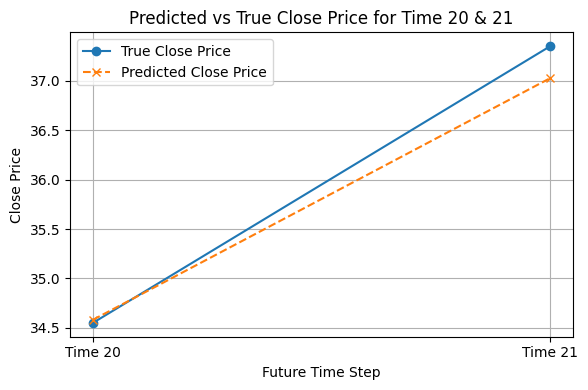

In [15]:
# Make prediction using rows 18-19 for input and predicting rows 20-21
k = 2
T = 2
start_index = 34

with torch.no_grad():
    window = full_X[start_index:start_index + k + T]
    window_y = full_y[start_index:start_index + k + T]

    x_k = window[:k].unsqueeze(0)  # shape: (1, k, num_features)
    # x_T = window[k:k+T, 0].view(1, T, 1)
    x_T = window[k:k+T].unsqueeze(0)  # shape: (1, T, num_features)
    y_T = window_y[k:k+T].unsqueeze(0)  # ground truth for future steps

    y_pred = model(x_k, x_T)  # model should already be on .double

    true_vals = y_T.squeeze().tolist()
    pred_vals = y_pred.squeeze().tolist()

# Print values
print("True values (Close):", true_vals)
print("Predicted values (Close):", pred_vals)

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.plot([0, 1], true_vals, label='True Close Price', marker='o')
plt.plot([0, 1], pred_vals, label='Predicted Close Price', linestyle='--', marker='x')
plt.xticks([0, 1], ['Time 20', 'Time 21'])
plt.title('Predicted vs True Close Price for Time 20 & 21')
plt.xlabel('Future Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[31.600000381469727, 34.150001525878906, 36.900001525878906, 39.849998474121094]
[36.41469396197915, 40.21936563846241]


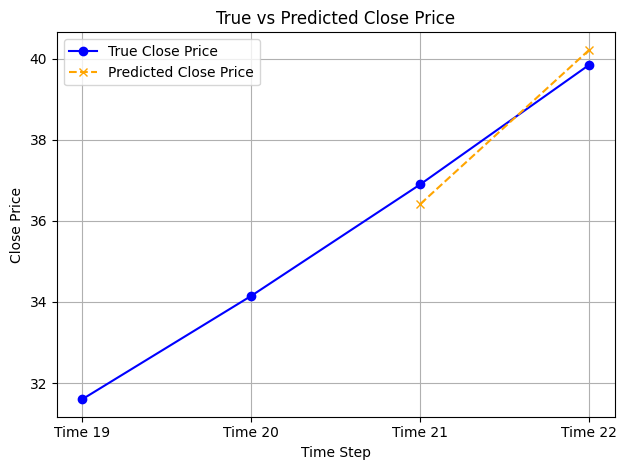

In [21]:


# --- Set parameters ---
k = 2  # past steps
T = 2  # future steps
start_index = 19  # starting index

# --- Make prediction ---
with torch.no_grad():
    window = full_X[start_index : start_index + k + T]
    window_y = full_y[start_index : start_index + k + T]

    x_k = window[:k].unsqueeze(0)               # shape: (1, k, num_features)
    x_T = window[k:k+T].unsqueeze(0)            # shape: (1, T, num_features)
    y_T = window_y[k:k+T].unsqueeze(0)          # future ground truth

    y_pred = model(x_k, x_T)

    true_vals = window_y.squeeze().tolist()     # true values from t=18 to t=21
    pred_vals = y_pred.squeeze().tolist()       # predicted values for t=20 to t=21

print(true_vals)
print(pred_vals)

# --- Plot ---
time_true = list(range(start_index, start_index + k + T))        # [18, 19, 20, 21]
time_pred = list(range(start_index + k, start_index + k + T))    # [20, 21]

plt.plot(time_true, true_vals, label='True Close Price', marker='o', color='blue')
plt.plot(time_pred, pred_vals, label='Predicted Close Price', linestyle='--', marker='x', color='orange')

plt.xticks(time_true, [f'Time {t}' for t in time_true])
plt.title('True vs Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
